In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import itertools
from pmdarima import auto_arima

from parser.resident_new_loans import get_new_loans_resident
from parser.resident_loans_volume import get_loans_volume_resident
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_measures

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

In [36]:
# метрика точности модели
# actual - фактические данные
# predict - предсказанные данные
def mape( actual , predict ): 
    actual, predict = np.array(actual), np.array(predict)
    actual_safe = np.where(actual == 0, 1e-10, actual)
    return np.mean(np.abs((actual - predict) / actual_safe))*100

# разделение данных на тренировочную и тестовую выборки по указанной дате
# dataframe - данные для деления
# date - дата, по которой происходит деление на выборки 
def divide_data(dataframe: pd.DataFrame, date: str):
    split_index = dataframe.index[dataframe['date'] == date]
    train_size = split_index[0]
    test_size = len(dataframe) - train_size
    train = dataframe[dataframe['date']<date]
    test = dataframe[dataframe['date']>=date]
    # Делаем из датафреймов серии
    train_data = train.copy()
    train_data.set_index(keys='date', drop=True, inplace=True)
    train_data = train_data.squeeze(axis=1)
    test_data = test.copy()
    test_data.set_index(keys='date', drop=True, inplace=True)
    test_data = test_data.squeeze(axis=1)
    return train_data, test_data

# Отрисовка графика данных и их прогноза с указанием названия прогнозируемой величины
# dataframe - исходные данные 
# predict - спрогнозированные данные
# name - название прогнозируемой величины
def show_plot(dataframe: pd.DataFrame, predict: pd.DataFrame, name, plt_title = 'Российская Федерация'):
    columns = list(dataframe)
    plt.figure(figsize=(12, 4))
    plt.plot(dataframe[columns[0]], dataframe[columns[1]].values/1e06)
    plt.plot(predict/1e6)
    plt.xlabel('Дата')
    plt.ylabel(name + ', трлн руб.')
    plt.title(plt_title)
    plt.grid(True)
    plt.show()

# Получение прогноза с помощью модели SARIMAX
# dataframe - исходные данные
# start_date - дата, от которой строится прогноз 
# last_predict_date - дата, до которой строится прогноз
# ct_trend - необходимо ли искусственно выпрямить тренд (True задает линейный тренд)
# custom - подбираем автоматически парамеры для настройки SARIMAX или передаем уже подобранные значения season_ord и custom_pdq
def get_data_predict(dataframe: pd.DataFrame, start_date: str, last_predict_date: str, trend='n', custom=False, season_ord = (1,1,1,12), custom_pdq = (1,1,1)):

    train_data, test_data = divide_data(dataframe, start_date)
    print('Фактические значения', pd.DataFrame({'Дата': test_data.index, 'Значения': test_data.values / 1e6}))
    # Подбор параметров
    if custom :
        s_ord = season_ord
        pdq = custom_pdq
    else :
        parameter_search = auto_arima(train_data, start_p = 1, start_q = 1, max_p = 3, max_q = 3, m = 12, start_P = 1,
                                  seasonal = True, d = None, D = 1, trace = False, error_action ='ignore',
                                  suppress_warnings = True,  stepwise = True) 
        s_ord = parameter_search.seasonal_order
        pdq = parameter_search.order
    # ОБУЧЕНИЕ МОДЕЛИ
    model = SARIMAX(train_data, order=pdq, seasonal_order=s_ord, trend=trend, measurement_error=True, enforce_stationarity=True, enforce_invertibility=True ) 
    model_fit = model.fit()
    # Получение предсказания
    pred = model_fit.get_prediction(start=start_date, end=last_predict_date, dynamic=False)
    predict = pred.predicted_mean
    test_pred = predict[0:len(test_data)]
    mp = mape(test_data.values, test_pred.values)
    return predict, mp

In [15]:
# Получаем список регионов
regions = get_measures()

In [ ]:
#посмотреть на список регионов
for key,value in regions.items():
    print(key, ' - ', value)

# Региональный разрез

## Объем кредитов, выданных резидентам

Фактические значения          Дата  Значения
0  2023-07-01  3.950763
1  2023-08-01  3.583795
2  2023-09-01  3.649110
3  2023-10-01  4.258271
4  2023-11-01  3.708338
5  2023-12-01  3.261644
6  2024-01-01  5.327820
7  2024-02-01  2.453103
8  2024-03-01  3.233747
9  2024-04-01  5.567906
10 2024-05-01  4.297891
Центральный федеральный округ 

Спрогнозированные значения:
2023-07-01    4.308358
2023-08-01    3.603282
2023-09-01    4.349055
2023-10-01    4.584984
2023-11-01    3.660316
2023-12-01    3.310207
2024-01-01    5.672478
2024-02-01    3.316747
2024-03-01    4.046006
2024-04-01    4.395340
2024-05-01    3.472222
2024-06-01    3.620555
2024-07-01    4.997447
2024-08-01    4.292371
2024-09-01    5.038144
2024-10-01    5.274073
2024-11-01    4.349405
2024-12-01    3.999296
2025-01-01    6.361567
2025-02-01    4.005836
2025-03-01    4.735095
2025-04-01    5.084429
2025-05-01    4.161311
2025-06-01    4.309644
2025-07-01    5.686536
2025-08-01    4.981460
2025-09-01    5.727233
2025-10-01

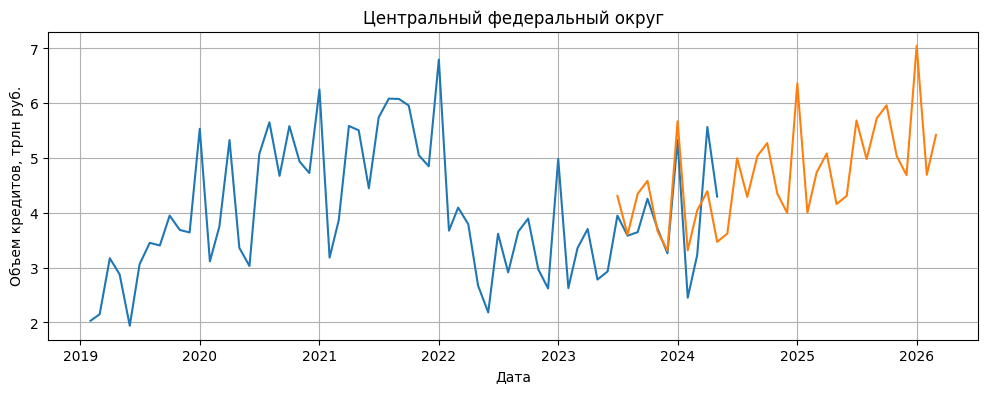

Фактические значения          Дата  Значения
0  2023-07-01  0.604305
1  2023-08-01  0.777717
2  2023-09-01  0.989391
3  2023-10-01  0.830283
4  2023-11-01  0.723472
5  2023-12-01  0.691444
6  2024-01-01  0.749438
7  2024-02-01  0.590614
8  2024-03-01  0.729302
9  2024-04-01  0.995074
10 2024-05-01  0.851607
Северо-Западный федеральный округ 

Спрогнозированные значения:
2023-07-01    0.644850
2023-08-01    0.587422
2023-09-01    0.477883
2023-10-01    0.695663
2023-11-01    0.548630
2023-12-01    0.507274
2024-01-01    0.813153
2024-02-01    0.433600
2024-03-01    0.504636
2024-04-01    0.593561
2024-05-01    0.597832
2024-06-01    0.438382
2024-07-01    0.603072
2024-08-01    0.448197
2024-09-01    0.401281
2024-10-01    0.573654
2024-11-01    0.462805
2024-12-01    0.441581
2025-01-01    0.631369
2025-02-01    0.438638
2025-03-01    0.457102
2025-04-01    0.578713
2025-05-01    0.518710
2025-06-01    0.531069
2025-07-01    0.631155
2025-08-01    0.539067
2025-09-01    0.451535
2025-1

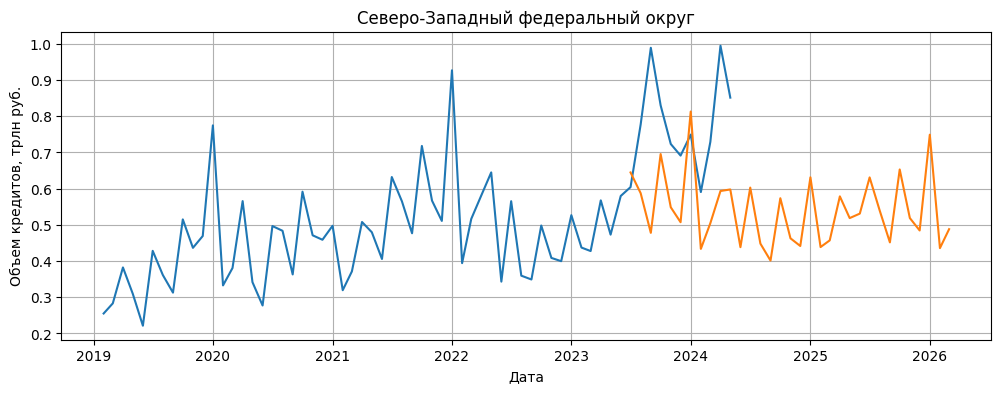

Фактические значения          Дата  Значения
0  2023-07-01  0.327145
1  2023-08-01  0.384757
2  2023-09-01  0.454792
3  2023-10-01  0.370928
4  2023-11-01  0.377049
5  2023-12-01  0.339817
6  2024-01-01  0.335724
7  2024-02-01  0.276832
8  2024-03-01  0.317122
9  2024-04-01  0.383772
10 2024-05-01  0.448459
Южный федеральный округ 

Спрогнозированные значения:
2023-07-01    0.316097
2023-08-01    0.318765
2023-09-01    0.300457
2023-10-01    0.309588
2023-11-01    0.270960
2023-12-01    0.283261
2024-01-01    0.351950
2024-02-01    0.305593
2024-03-01    0.340179
2024-04-01    0.342253
2024-05-01    0.238636
2024-06-01    0.239247
2024-07-01    0.281353
2024-08-01    0.296365
2024-09-01    0.283421
2024-10-01    0.288225
2024-11-01    0.241859
2024-12-01    0.258824
2025-01-01    0.321891
2025-02-01    0.310935
2025-03-01    0.351103
2025-04-01    0.363916
2025-05-01    0.271555
2025-06-01    0.277615
2025-07-01    0.308110
2025-08-01    0.314090
2025-09-01    0.297636
2025-10-01    0.

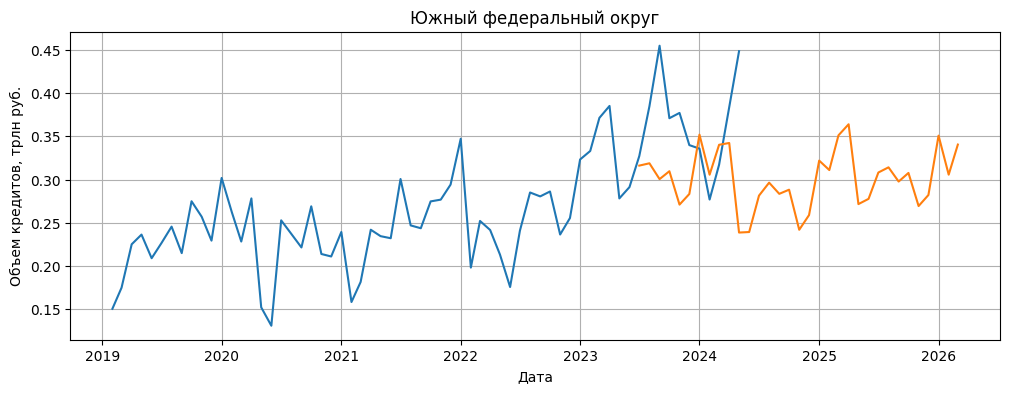

Фактические значения          Дата  Значения
0  2023-07-01  0.067659
1  2023-08-01  0.042391
2  2023-09-01  0.036784
3  2023-10-01  0.058902
4  2023-11-01  0.029621
5  2023-12-01  0.036892
6  2024-01-01  0.056118
7  2024-02-01  0.018463
8  2024-03-01  0.024761
9  2024-04-01  0.061312
10 2024-05-01  0.031216
Северо-Кавказский федеральный округ 

Спрогнозированные значения:
2023-07-01    0.051156
2023-08-01    0.033752
2023-09-01    0.034201
2023-10-01    0.062018
2023-11-01    0.038968
2023-12-01    0.055407
2024-01-01    0.071961
2024-02-01    0.035290
2024-03-01    0.033584
2024-04-01    0.056398
2024-05-01    0.036131
2024-06-01    0.042074
2024-07-01    0.058355
2024-08-01    0.042053
2024-09-01    0.041688
2024-10-01    0.062503
2024-11-01    0.043081
2024-12-01    0.070158
2025-01-01    0.078528
2025-02-01    0.045330
2025-03-01    0.039036
2025-04-01    0.068413
2025-05-01    0.041355
2025-06-01    0.048981
2025-07-01    0.065484
2025-08-01    0.048597
2025-09-01    0.048664
2025

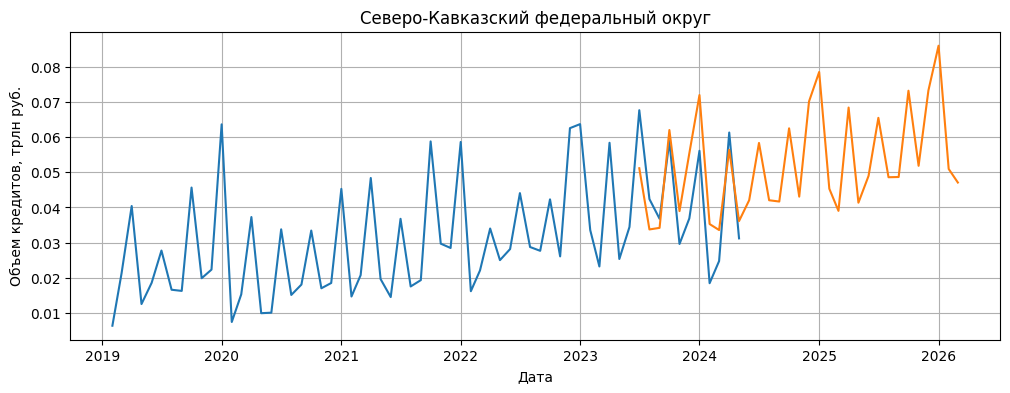

Фактические значения          Дата  Значения
0  2023-07-01  0.685990
1  2023-08-01  0.521547
2  2023-09-01  0.523846
3  2023-10-01  0.546248
4  2023-11-01  0.536594
5  2023-12-01  0.679172
6  2024-01-01  0.766947
7  2024-02-01  0.595980
8  2024-03-01  0.489605
9  2024-04-01  0.564982
10 2024-05-01  0.539290
Приволжский федеральный округ 

Спрогнозированные значения:
2023-07-01    0.501706
2023-08-01    0.400811
2023-09-01    0.402694
2023-10-01    0.514238
2023-11-01    0.435008
2023-12-01    0.425701
2024-01-01    0.627269
2024-02-01    0.312591
2024-03-01    0.361675
2024-04-01    0.538730
2024-05-01    0.484095
2024-06-01    0.510967
2024-07-01    0.516756
2024-08-01    0.418423
2024-09-01    0.420618
2024-10-01    0.536456
2024-11-01    0.455407
2024-12-01    0.445508
2025-01-01    0.644768
2025-02-01    0.321817
2025-03-01    0.371423
2025-04-01    0.566647
2025-05-01    0.507209
2025-06-01    0.540479
2025-07-01    0.535997
2025-08-01    0.436520
2025-09-01    0.438187
2025-10-01

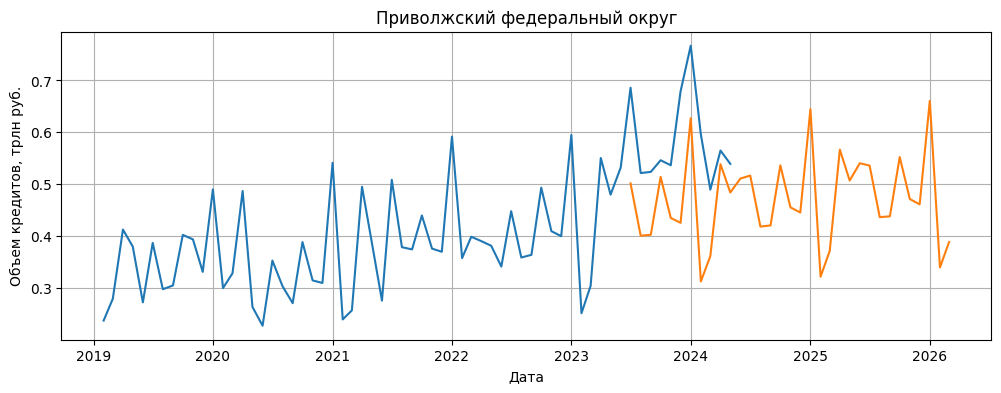

Фактические значения          Дата  Значения
0  2023-07-01  0.398612
1  2023-08-01  0.305695
2  2023-09-01  0.490140
3  2023-10-01  0.476375
4  2023-11-01  0.456716
5  2023-12-01  0.305001
6  2024-01-01  0.537365
7  2024-02-01  0.223854
8  2024-03-01  0.319851
9  2024-04-01  0.448220
10 2024-05-01  0.384722
Уральский федеральный округ 

Спрогнозированные значения:
2023-07-01    0.382261
2023-08-01    0.299824
2023-09-01    0.332095
2023-10-01    0.424773
2023-11-01    0.311592
2023-12-01    0.280246
2024-01-01    0.438513
2024-02-01    0.258842
2024-03-01    0.279466
2024-04-01    0.490962
2024-05-01    0.325918
2024-06-01    0.302742
2024-07-01    0.405566
2024-08-01    0.328278
2024-09-01    0.352909
2024-10-01    0.495656
2024-11-01    0.303879
2024-12-01    0.307709
2025-01-01    0.411079
2025-02-01    0.282630
2025-03-01    0.279731
2025-04-01    0.495038
2025-05-01    0.361073
2025-06-01    0.326043
2025-07-01    0.423091
2025-08-01    0.342509
2025-09-01    0.370542
2025-10-01  

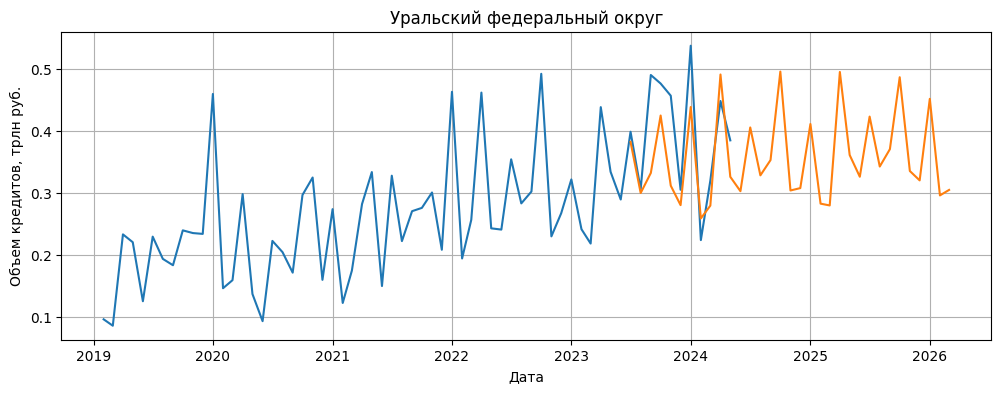

Фактические значения          Дата  Значения
0  2023-07-01  0.290808
1  2023-08-01  0.301365
2  2023-09-01  0.304866
3  2023-10-01  0.346025
4  2023-11-01  0.350683
5  2023-12-01  0.286043
6  2024-01-01  0.441906
7  2024-02-01  0.265292
8  2024-03-01  0.366467
9  2024-04-01  0.410570
10 2024-05-01  0.348270
Сибирский федеральный округ 

Спрогнозированные значения:
2023-07-01    0.299821
2023-08-01    0.298959
2023-09-01    0.337336
2023-10-01    0.312465
2023-11-01    0.288542
2023-12-01    0.304972
2024-01-01    0.367773
2024-02-01    0.243557
2024-03-01    0.330415
2024-04-01    0.334191
2024-05-01    0.342419
2024-06-01    0.264575
2024-07-01    0.328834
2024-08-01    0.327755
2024-09-01    0.365917
2024-10-01    0.340832
2024-11-01    0.316697
2024-12-01    0.332916
2025-01-01    0.395509
2025-02-01    0.271085
2025-03-01    0.357738
2025-04-01    0.361310
2025-05-01    0.369335
2025-06-01    0.291290
2025-07-01    0.355349
2025-08-01    0.354072
2025-09-01    0.392037
2025-10-01  

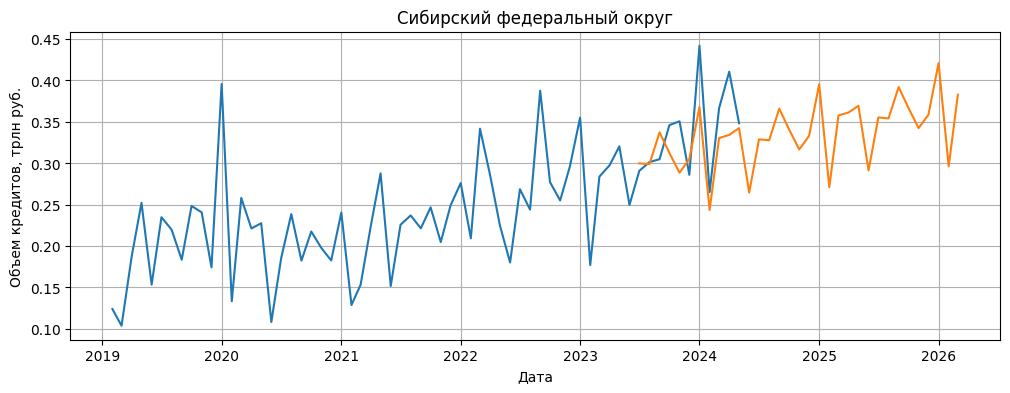

Фактические значения          Дата  Значения
0  2023-07-01  0.237945
1  2023-08-01  0.344953
2  2023-09-01  0.251415
3  2023-10-01  0.300901
4  2023-11-01  0.305410
5  2023-12-01  0.264621
6  2024-01-01  0.247128
7  2024-02-01  0.165039
8  2024-03-01  0.186507
9  2024-04-01  0.215172
10 2024-05-01  0.324941
Дальневосточный федеральный округ 

Спрогнозированные значения:
2023-07-01    0.207234
2023-08-01    0.191004
2023-09-01    0.115975
2023-10-01    0.225326
2023-11-01    0.259120
2023-12-01    0.127995
2024-01-01    0.163446
2024-02-01    0.153746
2024-03-01    0.088760
2024-04-01    0.193287
2024-05-01    0.198903
2024-06-01    0.144807
2024-07-01    0.197352
2024-08-01    0.166004
2024-09-01    0.112314
2024-10-01    0.205144
2024-11-01    0.245871
2024-12-01    0.118257
2025-01-01    0.162212
2025-02-01    0.161045
2025-03-01    0.083498
2025-04-01    0.210129
2025-05-01    0.221561
2025-06-01    0.152092
2025-07-01    0.207234
2025-08-01    0.191004
2025-09-01    0.115975
2025-1

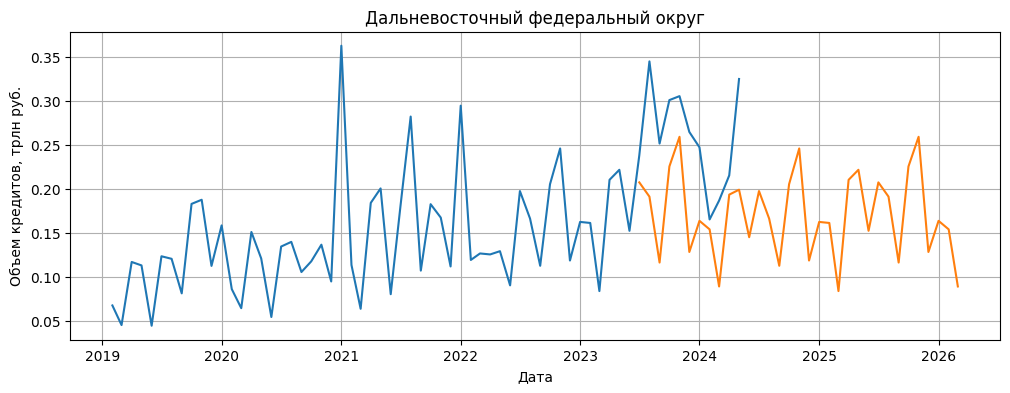

In [18]:
for key,value in regions.items():
    # Берем данные только по федеральным округам
    if key in [23, 42, 55, 64, 72, 87, 95, 106]:
        # получаем данные в формате датафрейма
        new_loans_resident_df = get_new_loans_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2)
        # определяем дату, до которой возьмем данные для обучения модели
        split_date = '2023-07'
        # определяем дату, до которой определяем прогноз
        last_predict_date = '2026-03'
        # Составляем прогноз
        predict, mp = get_data_predict(new_loans_resident_df, split_date, last_predict_date)
        print(value, "\n")
        print("Спрогнозированные значения:")
        print(predict/1e06)
        print("MAPE = ", mp)
        # визуализируем данные и прогноз по ним
        show_plot(new_loans_resident_df, predict, 'Объем кредитов', value)

         date  resident_loans_volume
0  2019-02-01           67143.685185
1  2019-03-01           44801.498677
2  2019-04-01          116634.816138
3  2019-05-01          112720.685185
4  2019-06-01           44060.498677
5  2019-07-01          123125.816138
6  2019-08-01          120233.685185
7  2019-09-01           80876.498677
8  2019-10-01          182736.816138
9  2019-11-01          187453.685185
10 2019-12-01          112141.498677
11 2020-01-01          158278.816138
12 2020-02-01           85737.685185
13 2020-03-01           64032.498677
14 2020-04-01          150763.816138
15 2020-05-01          120599.685185
16 2020-06-01           54000.498677
17 2020-07-01          134195.816138
18 2020-08-01          139514.685185
19 2020-09-01          105169.498677
20 2020-10-01          117342.816138
21 2020-11-01          136298.685185
22 2020-12-01           94464.498677
23 2021-01-01          362792.816138
Фактические значения          Дата  Значения
0  2023-05-01  0.221561
1  202

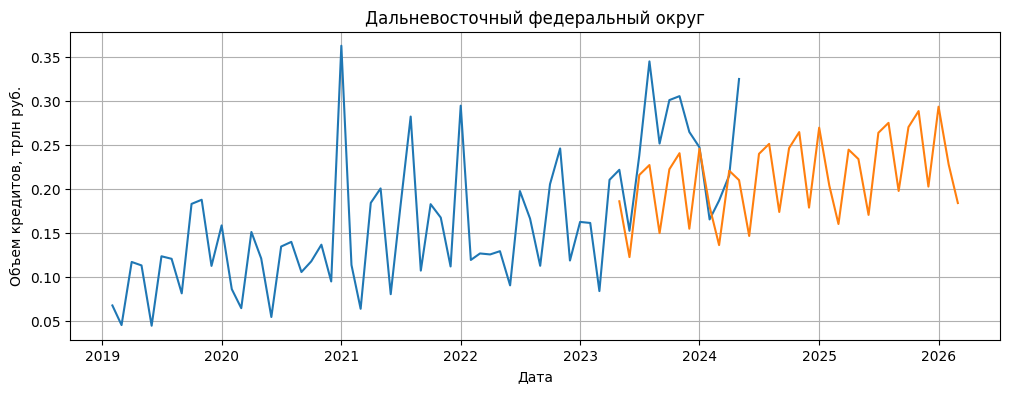

In [9]:
# подправим дальневосточный округ
value = "Дальневосточный федеральный округ"
key = 106
FEFD_new_loans_df = get_new_loans_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2)
print(FEFD_new_loans_df[FEFD_new_loans_df['date'] < '2021-02'])
# В строке 23 (2021-01-01          362792.816138) - резкий скачок данных. Их необходимо искуственно сгладить
c_df = FEFD_new_loans_df.copy()
c_df.at[23, 'resident_loans_volume'] = c_df.at[23, 'resident_loans_volume'] / 1.5

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-05'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Составляем прогноз
predict, mp = get_data_predict(c_df, split_date, last_predict_date)
print(value, "\n")
print("Спрогнозированные значения:")
print(predict/1e06)
print("MAPE = ", mp)

# визуализируем данные и прогноз по ним
show_plot(FEFD_new_loans_df, predict, 'Объем кредитов', value)

Фактические значения         Дата  Значения
0 2023-08-01  0.521547
1 2023-09-01  0.523846
2 2023-10-01  0.546248
3 2023-11-01  0.536594
4 2023-12-01  0.679172
5 2024-01-01  0.766947
6 2024-02-01  0.595980
7 2024-03-01  0.489605
8 2024-04-01  0.564982
9 2024-05-01  0.539290
Приволжский федеральный округ 

Спрогнозированные значения:
2023-08-01    0.463289
2023-09-01    0.439519
2023-10-01    0.566617
2023-11-01    0.486433
2023-12-01    0.479480
2024-01-01    0.680466
2024-02-01    0.356159
2024-03-01    0.408976
2024-04-01    0.616622
2024-05-01    0.557567
2024-06-01    0.597058
2024-07-01    0.745067
2024-08-01    0.545368
2024-09-01    0.527992
2024-10-01    0.657280
2024-11-01    0.578299
2024-12-01    0.572739
2025-01-01    0.774567
2025-02-01    0.449016
2025-03-01    0.503646
2025-04-01    0.719241
2025-05-01    0.660142
2025-06-01    0.703484
2025-07-01    0.854194
2025-08-01    0.652644
2025-09-01    0.636057
2025-10-01    0.766801
2025-11-01    0.689432
2025-12-01    0.685454

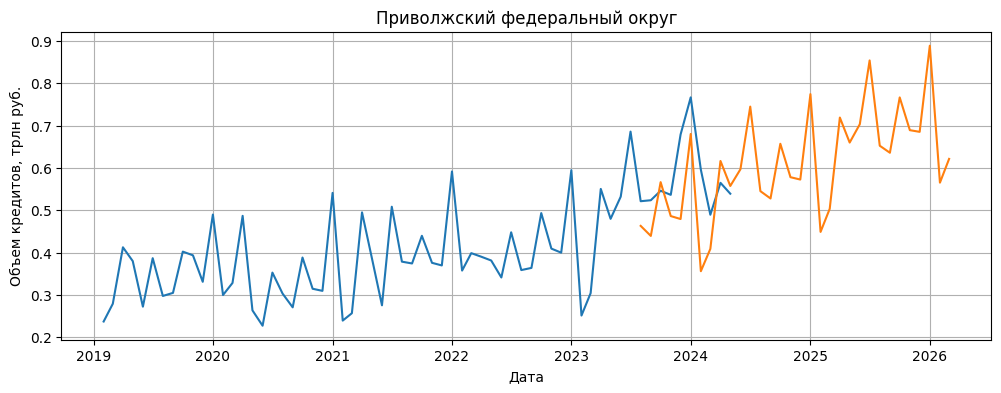

In [27]:
# подправим Приволжский округ
value = "Приволжский федеральный округ"
key = 72
VFD_new_loans_df = get_new_loans_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2)
# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-08'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Составляем прогноз
predict, mp = get_data_predict(VFD_new_loans_df, split_date, last_predict_date, 'ct')
print(value, "\n")
print("Спрогнозированные значения:")
print(predict/1e06)
print("MAPE = ", mp)

# визуализируем данные и прогноз по ним
show_plot(VFD_new_loans_df, predict, 'Объем кредитов', value)

## Объем задолженности резидентов

Фактические значения          Дата   Значения
0  2023-05-01  28.989946
1  2023-06-01  29.449881
2  2023-07-01  29.979803
3  2023-08-01  30.743432
4  2023-09-01  31.596519
5  2023-10-01  32.422214
6  2023-11-01  33.080711
7  2023-12-01  33.528586
8  2024-01-01  33.831092
9  2024-02-01  33.868796
10 2024-03-01  34.347838
11 2024-04-01  35.022982
12 2024-05-01  35.616112
Центральный федеральный округ 

Спрогнозированные значения:
2023-05-01    28.388613
2023-06-01    28.250150
2023-07-01    28.544731
2023-08-01    28.851099
2023-09-01    29.814177
2023-10-01    30.299588
2023-11-01    30.951097
2023-12-01    31.596897
2024-01-01    32.390593
2024-02-01    33.187241
2024-03-01    33.966430
2024-04-01    34.809053
2024-05-01    35.060980
2024-06-01    35.143013
2024-07-01    35.662173
2024-08-01    36.197237
2024-09-01    37.393107
2024-10-01    38.115418
2024-11-01    39.007928
2024-12-01    39.898834
2025-01-01    40.941740
2025-02-01    41.991701
2025-03-01    43.028307
2025-04-01    44.

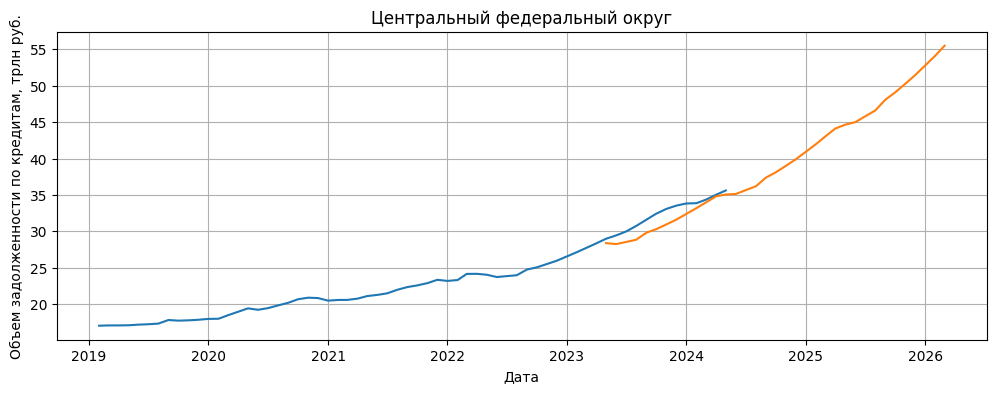

Фактические значения          Дата  Значения
0  2023-05-01  6.843280
1  2023-06-01  7.042544
2  2023-07-01  7.223055
3  2023-08-01  7.579943
4  2023-09-01  7.754339
5  2023-10-01  8.136135
6  2023-11-01  8.301850
7  2023-12-01  8.362454
8  2024-01-01  8.613018
9  2024-02-01  8.832835
10 2024-03-01  8.896591
11 2024-04-01  9.178228
12 2024-05-01  9.315763
Северо-Западный федеральный округ 

Спрогнозированные значения:
2023-05-01     6.879842
2023-06-01     6.859357
2023-07-01     6.872824
2023-08-01     6.951732
2023-09-01     7.053621
2023-10-01     7.420685
2023-11-01     7.766839
2023-12-01     8.079626
2024-01-01     8.457217
2024-02-01     8.804408
2024-03-01     8.831527
2024-04-01     9.024993
2024-05-01     9.273151
2024-06-01     9.309229
2024-07-01     9.379605
2024-08-01     9.515768
2024-09-01     9.675256
2024-10-01    10.100267
2024-11-01    10.504712
2024-12-01    10.876136
2025-01-01    11.312710
2025-02-01    11.719230
2025-03-01    11.806022
2025-04-01    12.059509
202

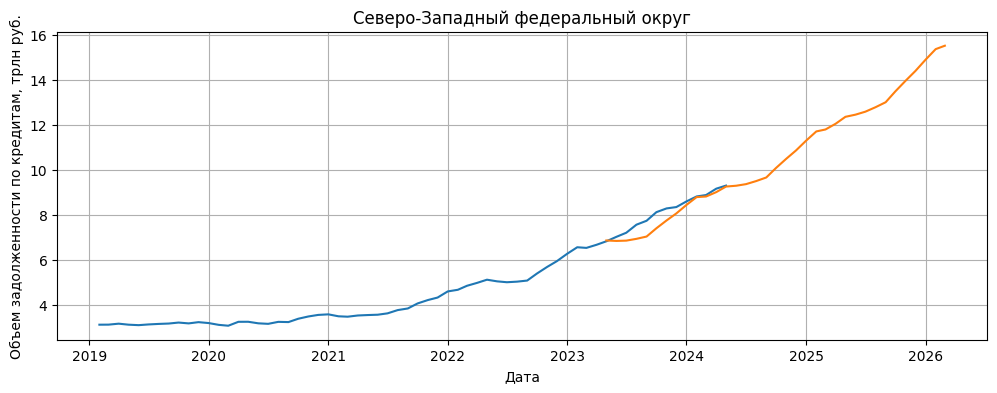

Фактические значения          Дата  Значения
0  2023-05-01  3.143270
1  2023-06-01  3.202447
2  2023-07-01  3.226577
3  2023-08-01  3.273357
4  2023-09-01  3.334474
5  2023-10-01  3.393196
6  2023-11-01  3.468457
7  2023-12-01  3.491352
8  2024-01-01  3.579862
9  2024-02-01  3.645155
10 2024-03-01  3.680993
11 2024-04-01  3.715722
12 2024-05-01  3.808006
Южный федеральный округ 

Спрогнозированные значения:
2023-05-01    3.105030
2023-06-01    3.080057
2023-07-01    3.096839
2023-08-01    3.218755
2023-09-01    3.368918
2023-10-01    3.515142
2023-11-01    3.671983
2023-12-01    3.721140
2024-01-01    3.732728
2024-02-01    3.851001
2024-03-01    3.955745
2024-04-01    4.052809
2024-05-01    4.102535
2024-06-01    4.108638
2024-07-01    4.156957
2024-08-01    4.310872
2024-09-01    4.493494
2024-10-01    4.672640
2024-11-01    4.862862
2024-12-01    4.945862
2025-01-01    4.991755
2025-02-01    5.144792
2025-03-01    5.284763
2025-04-01    5.417514
2025-05-01    5.503388
2025-06-01    

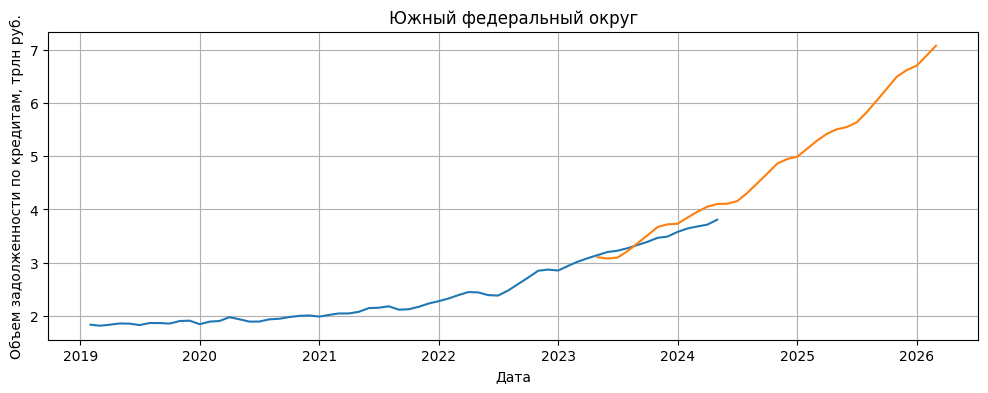

Фактические значения         Дата  Значения
0 2023-12-01  0.549520
1 2024-01-01  0.553694
2 2024-02-01  0.556139
3 2024-03-01  0.556833
4 2024-04-01  0.572405
5 2024-05-01  0.584337
Северо-Кавказский федеральный округ 

Спрогнозированные значения:
2023-12-01    0.574098
2024-01-01    0.598149
2024-02-01    0.619026
2024-03-01    0.626600
2024-04-01    0.639778
2024-05-01    0.646386
2024-06-01    0.656661
2024-07-01    0.673256
2024-08-01    0.663467
2024-09-01    0.665487
2024-10-01    0.672742
2024-11-01    0.670290
2024-12-01    0.691864
2025-01-01    0.717412
2025-02-01    0.739785
2025-03-01    0.748857
2025-04-01    0.763530
2025-05-01    0.771635
2025-06-01    0.783408
2025-07-01    0.801499
2025-08-01    0.793207
2025-09-01    0.796724
2025-10-01    0.805475
2025-11-01    0.804520
2025-12-01    0.827590
2026-01-01    0.854635
2026-02-01    0.878505
2026-03-01    0.889073
Freq: MS, Name: predicted_mean, dtype: float64
MAPE =  9.787852309397978


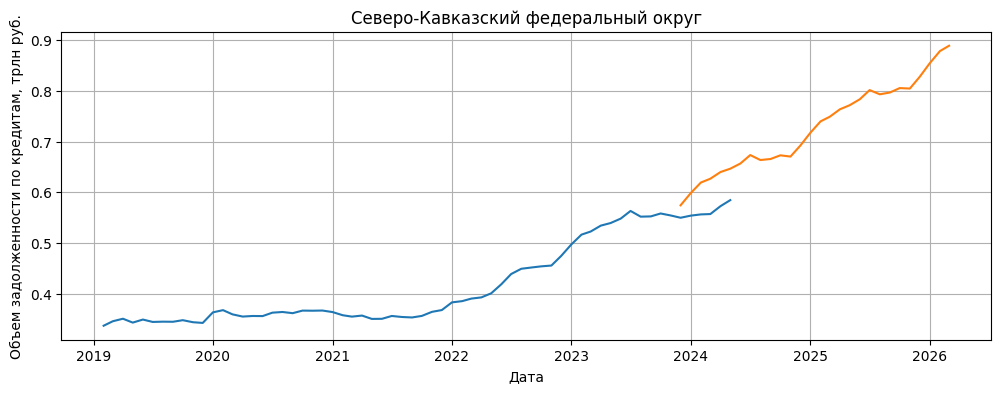

Фактические значения         Дата  Значения
0 2023-12-01  5.303962
1 2024-01-01  5.392864
2 2024-02-01  5.446049
3 2024-03-01  5.488150
4 2024-04-01  5.506794
5 2024-05-01  5.629391
Приволжский федеральный округ 

Спрогнозированные значения:
2023-12-01    5.309391
2024-01-01    5.311172
2024-02-01    5.337997
2024-03-01    5.418014
2024-04-01    5.514798
2024-05-01    5.660983
2024-06-01    5.795694
2024-07-01    5.966700
2024-08-01    6.149914
2024-09-01    6.243339
2024-10-01    6.337201
2024-11-01    6.461809
2024-12-01    6.599517
2025-01-01    6.623687
2025-02-01    6.672899
2025-03-01    6.775303
2025-04-01    6.894475
2025-05-01    7.063048
2025-06-01    7.220147
2025-07-01    7.413540
2025-08-01    7.619142
2025-09-01    7.734954
2025-10-01    7.851204
2025-11-01    7.998199
2025-12-01    8.158295
2026-01-01    8.204852
2026-02-01    8.276452
2026-03-01    8.401244
Freq: MS, Name: predicted_mean, dtype: float64
MAPE =  0.9309510978601246


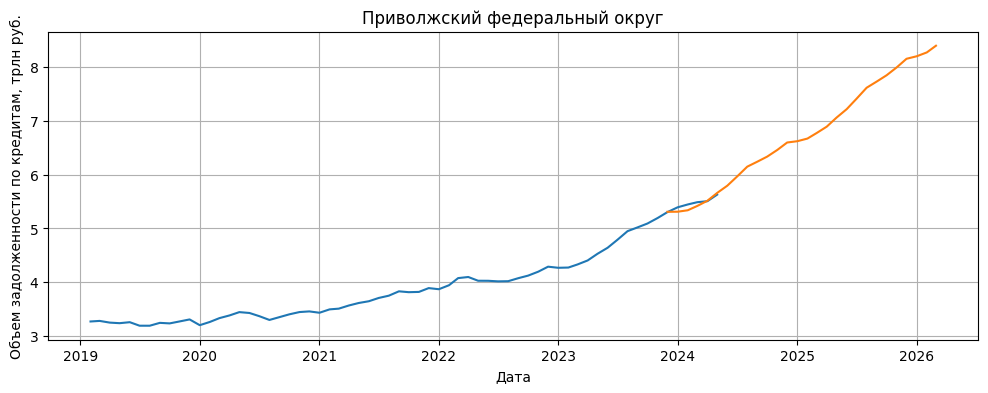

Фактические значения          Дата  Значения
0  2023-05-01  4.813397
1  2023-06-01  4.862824
2  2023-07-01  4.993919
3  2023-08-01  5.128241
4  2023-09-01  5.287704
5  2023-10-01  5.349493
6  2023-11-01  5.386946
7  2023-12-01  5.391242
8  2024-01-01  5.397525
9  2024-02-01  5.410592
10 2024-03-01  5.336221
11 2024-04-01  5.419126
12 2024-05-01  5.508052
Уральский федеральный округ 

Спрогнозированные значения:
2023-05-01    4.739314
2023-06-01    4.644846
2023-07-01    4.707131
2023-08-01    4.779282
2023-09-01    4.862408
2023-10-01    4.880840
2023-11-01    5.028288
2023-12-01    5.119546
2024-01-01    5.275922
2024-02-01    5.272896
2024-03-01    5.365153
2024-04-01    5.527247
2024-05-01    5.533466
2024-06-01    5.449531
2024-07-01    5.522365
2024-08-01    5.605027
2024-09-01    5.698624
2024-10-01    5.727501
2024-11-01    5.885385
2024-12-01    5.987034
2025-01-01    6.153794
2025-02-01    6.161069
2025-03-01    6.263595
2025-04-01    6.436011
2025-05-01    6.452476
2025-06-01

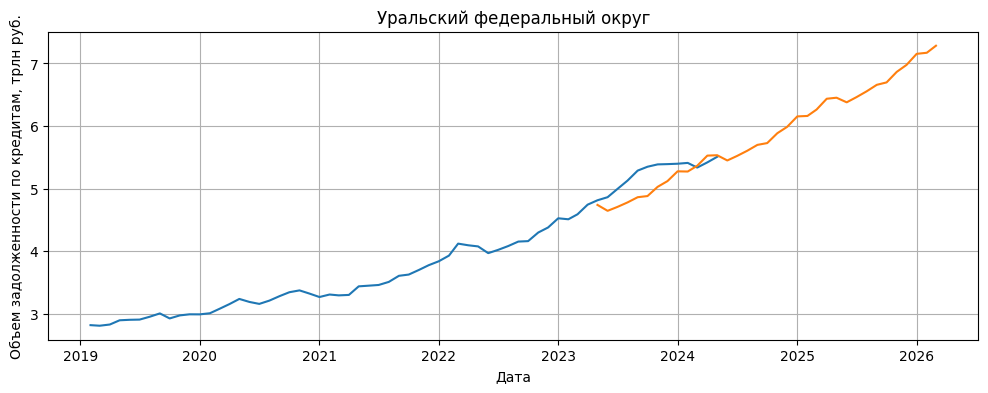

Фактические значения         Дата  Значения
0 2023-12-01  3.377852
1 2024-01-01  3.469376
2 2024-02-01  3.465888
3 2024-03-01  3.575766
4 2024-04-01  3.602634
5 2024-05-01  3.652537
Сибирский федеральный округ 

Спрогнозированные значения:
2023-12-01    3.418150
2024-01-01    3.399275
2024-02-01    3.404414
2024-03-01    3.504764
2024-04-01    3.515844
2024-05-01    3.570018
2024-06-01    3.490342
2024-07-01    3.693136
2024-08-01    3.939573
2024-09-01    4.160574
2024-10-01    4.233658
2024-11-01    4.296959
2024-12-01    4.305398
2025-01-01    4.298230
2025-02-01    4.315075
2025-03-01    4.427132
2025-04-01    4.449919
2025-05-01    4.515799
2025-06-01    4.447830
2025-07-01    4.662330
2025-08-01    4.920473
2025-09-01    5.153180
2025-10-01    5.237971
2025-11-01    5.312978
2025-12-01    5.333124
2026-01-01    5.337662
2026-02-01    5.366214
2026-03-01    5.489977
Freq: MS, Name: predicted_mean, dtype: float64
MAPE =  1.940192675144278


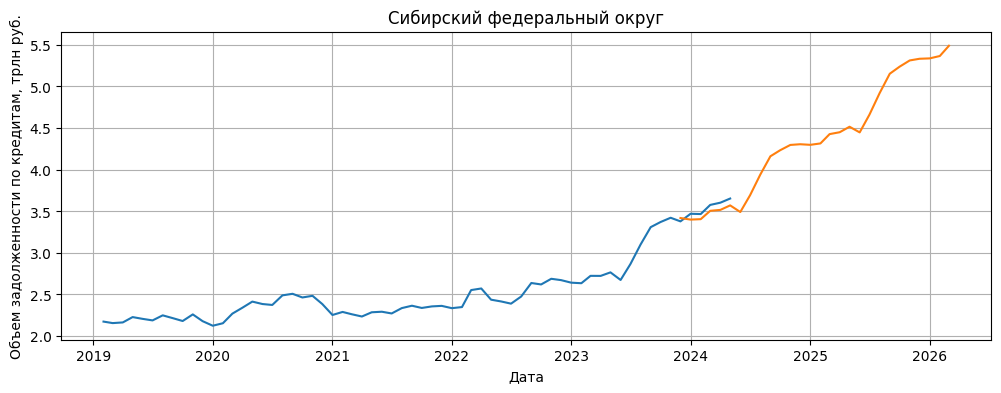

Фактические значения         Дата  Значения
0 2023-12-01  3.730613
1 2024-01-01  3.754824
2 2024-02-01  3.781700
3 2024-03-01  3.876387
4 2024-04-01  3.945293
5 2024-05-01  4.039298
Дальневосточный федеральный округ 

Спрогнозированные значения:
2023-12-01    3.687727
2024-01-01    3.719336
2024-02-01    3.873144
2024-03-01    3.845499
2024-04-01    3.861172
2024-05-01    3.852446
2024-06-01    3.824773
2024-07-01    3.842769
2024-08-01    3.905505
2024-09-01    3.911920
2024-10-01    3.953767
2024-11-01    4.030265
2024-12-01    4.022196
2025-01-01    4.045816
2025-02-01    4.191635
2025-03-01    4.156002
2025-04-01    4.163686
2025-05-01    4.146972
2025-06-01    4.111310
2025-07-01    4.121318
2025-08-01    4.176066
2025-09-01    4.174492
2025-10-01    4.208350
2025-11-01    4.276860
2025-12-01    4.260802
2026-01-01    4.276434
2026-02-01    4.414265
2026-03-01    4.370643
Freq: MS, Name: predicted_mean, dtype: float64
MAPE =  2.0112696617544894


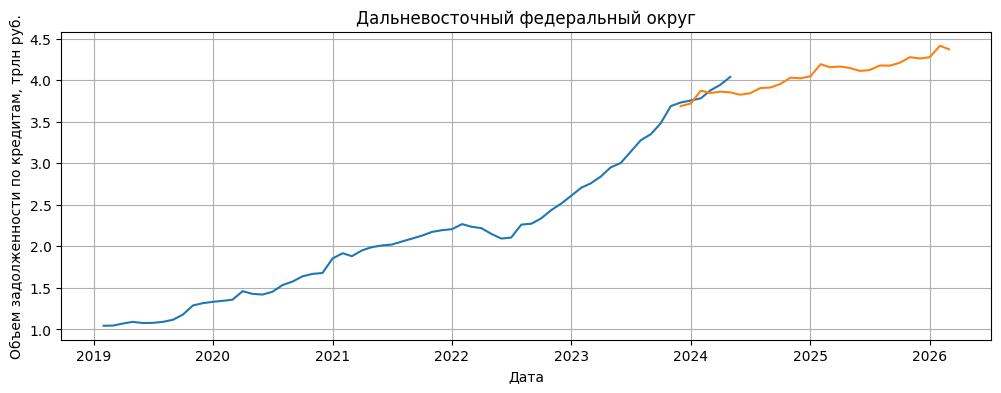

In [21]:
for key,value in regions.items():
    # Берем данные только по федеральным округам
    if key in [23, 42, 55, 87]:
        # получаем данные в формате датафрейма
        loans_volume_resident_df = get_loans_volume_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2)
        # определяем дату, до которой возьмем данные для обучения модели
        split_date = '2023-05'
        # определяем дату, до которой определяем прогноз
        last_predict_date = '2026-03'
        # Составляем прогноз
        predict, mp = get_data_predict(loans_volume_resident_df, split_date, last_predict_date, 'ct')
        print(value, "\n")
        print("Спрогнозированные значения:")
        print(predict/1e06)
        print("MAPE = ", mp)
        # визуализируем данные и прогноз по ним
        show_plot(loans_volume_resident_df, predict, 'Объем задолженности по кредитам', value)
    if key in [64, 72, 95, 106]:
        # получаем данные в формате датафрейма
        loans_volume_resident_df =  get_loans_volume_resident(measure_id=key, spike_remove=True, window_size=3, sigma=2)
        # определяем дату, до которой возьмем данные для обучения модели
        split_date = '2023-12'
        # определяем дату, до которой определяем прогноз
        last_predict_date = '2026-03'
        # Составляем прогноз
        predict, mp = get_data_predict(loans_volume_resident_df, split_date, last_predict_date, 'c')
        print(value, "\n")
        print("Спрогнозированные значения:")
        print(predict/1e06)
        print("MAPE = ", mp)
        # визуализируем данные и прогноз по ним
        show_plot(loans_volume_resident_df, predict, 'Объем задолженности по кредитам', value)

# Временной разрез

## Объем кредитов, выданных резидентам

Фактические значения          Дата  Значения
0  2023-07-01  6.558962
1  2023-08-01  6.788170
2  2023-09-01  6.707030
3  2023-10-01  7.151898
4  2023-11-01  7.068007
5  2023-12-01  5.864633
6  2024-01-01  9.172652
7  2024-02-01  7.025051
8  2024-03-01  5.667363
9  2024-04-01  8.647007
10 2024-05-01  7.226396
Российская федерация 

Спрогнозированные значения:
2023-07-01    6.994188
2023-08-01    6.250886
2023-09-01    6.718641
2023-10-01    7.526753
2023-11-01    6.696530
2023-12-01    5.974488
2024-01-01    6.926071
2024-02-01    5.578988
2024-03-01    6.548728
2024-04-01    7.644762
2024-05-01    6.532192
2024-06-01    6.370344
2024-07-01    8.141417
2024-08-01    7.627872
2024-09-01    7.890944
2024-10-01    8.640758
2024-11-01    7.911569
2024-12-01    7.312869
2025-01-01    8.462658
2025-02-01    7.034619
2025-03-01    7.854049
2025-04-01    8.923414
2025-05-01    7.912114
2025-06-01    7.583222
2025-07-01    9.265657
2025-08-01    8.877220
2025-09-01    9.028838
2025-10-01    9.746

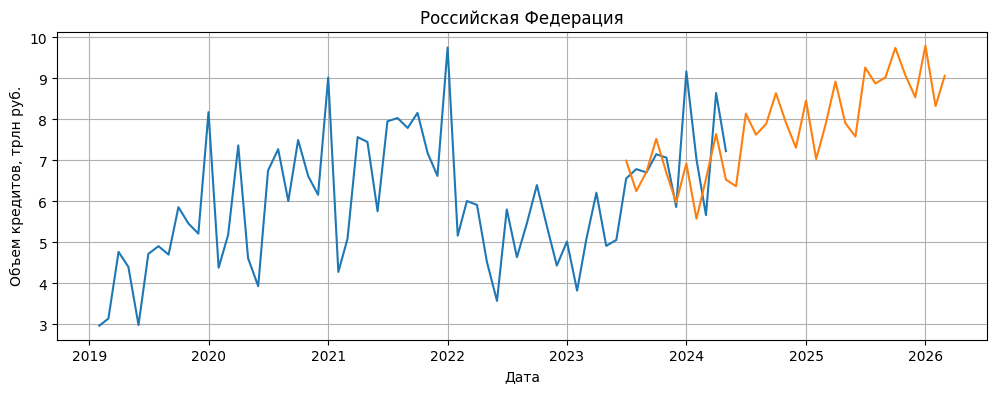

In [32]:
new_loans_resident_df =get_new_loans_resident(measure_id=22, spike_remove=True, window_size=3, sigma=2)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-07'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'
s_ord = (1,1,1,12)
pdq = (0,1,0)


# Составляем прогноз
predict, mp = get_data_predict(new_loans_resident_df, split_date, last_predict_date, custom = True,  season_ord = s_ord, custom_pdq = pdq)
print("Российская федерация", "\n")
print("Спрогнозированные значения:")
print(predict/1e06)
print("MAPE = ", mp)


# визуализируем данные и прогноз по ним
show_plot(new_loans_resident_df, predict, 'Объем кредитов')

## Объем задолженности резидентов

Фактические значения          Дата   Значения
0  2023-05-01  54.571368
1  2023-06-01  55.421625
2  2023-07-01  56.597813
3  2023-08-01  58.778446
4  2023-09-01  60.276405
5  2023-10-01  61.800476
6  2023-11-01  63.029903
7  2023-12-01  63.807040
8  2024-01-01  64.802129
9  2024-02-01  65.007154
10 2024-03-01  65.758778
11 2024-04-01  66.948815
12 2024-05-01  68.153497
Российская федерация 

Спрогнозированные значения:
2023-05-01    52.921620
2023-06-01    52.280858
2023-07-01    52.594720
2023-08-01    52.954056
2023-09-01    54.125676
2023-10-01    54.882854
2023-11-01    56.528574
2023-12-01    57.299111
2024-01-01    58.339463
2024-02-01    59.410750
2024-03-01    60.347888
2024-04-01    61.504038
2024-05-01    61.054775
2024-06-01    60.413567
2024-07-01    60.727104
2024-08-01    61.086203
2024-09-01    62.257650
2024-10-01    63.014701
2024-11-01    64.660329
2024-12-01    65.430799
2025-01-01    66.471102
2025-02-01    67.542354
2025-03-01    68.479466
2025-04-01    69.635596
20

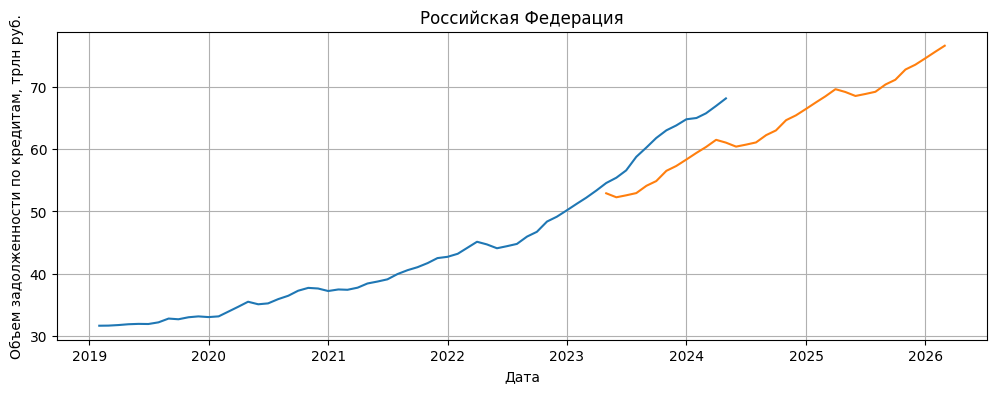

In [37]:
loans_volume_resident_df = get_loans_volume_resident(measure_id=22, spike_remove=True, window_size=3, sigma=2)

# определяем дату, до которой возьмем данные для обучения модели
split_date = '2023-05'
# определяем дату, до которой определяем прогноз
last_predict_date = '2026-03'

# Подбор параметров вручную
s_ord = (1,1,1,12)
pdq = (1,1,1)

# Составляем прогноз
predict, mp = get_data_predict(loans_volume_resident_df , split_date, last_predict_date)
print("Российская федерация", "\n")
print("Спрогнозированные значения:")
print(predict/1e06)
print("MAPE = ", mp)


# визуализируем данные и прогноз по ним
show_plot(loans_volume_resident_df, predict, 'Объем задолженности по кредитам')